## Experimentation with GravNet_Conv

In [440]:
import torch_geometric
import torch
import os
import tarfile
import math
import random

### 1. Obtain data for training

In [441]:
raw_data_dir = "../raw_data"
output_dir = "../data"

In [453]:
for filename in os.listdir(raw_data_dir):
    if filename.endswith("2_1.tar.gz"):
        tar_gz_path = os.path.join(raw_data_dir, filename)
        tar = tarfile.open(tar_gz_path, "r:gz")
        tar.extractall()
        tar.close()

In [ ]:
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".tar.gz"):
        tar_gz_path = os.path.join(raw_data_dir, filename)
        tar = tarfile.open(tar_gz_path, "r:gz")
        tar.extractall(output_dir)
        tar.close()

In [443]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(device)

cpu


In [445]:
raw_data = []

for foldername in os.listdir(output_dir):
    folder = os.path.join(output_dir, foldername)
    for filename in os.listdir(folder):
        if filename.endswith(".pt"):
            file = os.path.join(folder, filename)
            raw_data.append(torch.load(file).to(device))

random.shuffle(raw_data)

In [448]:
print(raw_data[1000])

Data(x=[314, 7], edge_index=[2, 2640], edge_attr=[2640, 4], y=[2640], pt=[314], particle_id=[314], reconstructable=[314], sector=[314], evtid=[1], s=[1])


### 2. Observe point cloud properties

In [368]:
print("Length of dataset:", len(raw_data))
print(raw_data[0].x.size())
print(raw_data[0].particle_id.size())
print(torch.unique(raw_data[0].particle_id).size())

Length of dataset: 900
torch.Size([6664, 7])
torch.Size([6664])
torch.Size([1016])


### 3. Loss function initializatinon

`strength_loss` aims to maximize condensation strength of condensation points, minimize condensation strength of non-condensation points.

$\frac{1}{|K|}\sum_{i \in K}(1 - \beta_{i})^2 + \frac{\epsilon}{|N| - |K|}\sum_{i \in (N/K)}(\beta_{i})^2$

In [369]:
def strength_loss(I, A, epsilon=1):
    unique_ids = torch.unique(I)
    max_weights = torch.empty((unique_ids.shape[0],), dtype=A.dtype).to(A.device)
    other_weights = torch.empty((0,), dtype=A.dtype).to(A.device)

    for idx, uid in enumerate(unique_ids):
        mask = I == uid
        weights = A[mask]

        max_weight = torch.max(weights)
        max_weights[idx] = max_weight

        non_max_mask = weights != max_weight
        non_max_weights = torch.masked_select(weights, non_max_mask)

        other_weights = torch.cat([other_weights, non_max_weights])

    loss_a = ((1 - max_weights) ** 2).mean()
    loss_b = ((other_weights)**2).mean()
    return (4 / (1 + epsilon) * (loss_a + epsilon*loss_b)), (4 * loss_a.item()), (4 * loss_b.item())


`potential_loss` aims minimize pairwise distance between hits and their respective condensation points while maintaining distance of at least 1 with other condensation points.

$\frac{1}{|N||K|}\sum_{j=1}^N\sum_{k=1}^K max(1 - ||x_{\alpha k} - x_j||, 0) + \frac{\epsilon'}{|N|}\sum_{j=1}^N ||x_{\alpha j} - x_j||^2$

In [370]:

def gather_max_elements(ID, weight, position):
    """Find the item with the largest weight for each unique ID."""
    unique_ids = torch.unique(ID)
    max_positions = []
    max_weights = []
    for uid in unique_ids:
        indices = (ID == uid)
        weights = weight[indices]
        positions = position[indices]
        max_idx = torch.argmax(weights)
        max_positions.append(positions[max_idx])
        max_weights.append(weight[max_idx])
    return torch.stack(max_positions), torch.stack(max_weights), unique_ids

def pairwise_distance(a, b):
    """Calculate pairwise distances between vectors (positions) in two different batches."""
    diff = a.unsqueeze(1) - b.unsqueeze(0)
    dist = torch.sqrt(torch.sum(diff**2, dim=-1) + 1e-8) # add a small number to avoid numerical instability
    return dist

def find_condensation_positions(ID_1, Pos_1, ID_2):
    """Find the representative position in Pos_1 for each ID in ID_2."""
    mapping = {id.item(): pos for id, pos in zip(ID_1, Pos_1)}
    return torch.stack([mapping[id.item()] for id in ID_2])

def potential_loss(ID, weight, position):
    con_position, _, con_ids = gather_max_elements(ID, weight, position)

    pairwise_dist = pairwise_distance(con_position, position)
    dist_transformed = torch.clamp(1 - pairwise_dist, min=0)
    repulsive_loss =  torch.mean(dist_transformed)

    condensation_positions = find_condensation_positions(con_ids, con_position, ID)
    
    # Compute squared Euclidean distance
    diff = position - condensation_positions
    attractive_loss = torch.mean(torch.sum(diff**2, dim=-1))
    
    # Average the squared distances
    return (2 * (attractive_loss + repulsive_loss)), (4 * repulsive_loss.item()), (4 * attractive_loss.item())


In [371]:
def loss_function(ID, weight, position):
    l1, a, b = strength_loss(ID, weight)
    l2, c, d = potential_loss(ID, weight, position)
    return ((l1+l2)/2), a, b, c, d

#### 4. Training Loop

In [385]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.gravnet1 = torch_geometric.nn.conv.GravNetConv(in_channels=7, out_channels=7, space_dimensions=4, propagate_dimensions=16, k=16)
        self.gravnet2 = torch_geometric.nn.conv.GravNetConv(in_channels=7, out_channels=3, space_dimensions=4, propagate_dimensions=16, k=16)
        self.activation = torch.nn.LeakyReLU()

    def forward(self, x):
        return self.gravnet2(self.activation(self.gravnet1(x)))

gravnet = Model()

In [386]:
optimizer = torch.optim.Adam(gravnet.parameters(), lr=0.005)

In [387]:
normalization_factor = torch.abs(gravnet(raw_data[0].x)).mean().item()
print(normalization_factor)

27.80196762084961


In [388]:
data_index = 0
loss_storage = []
iteration = 0

In [ ]:
while True:
    iteration += 1
    optimizer.zero_grad()
    y = gravnet(raw_data[data_index].x) / normalization_factor
    loss, a, b, c, d = loss_function(raw_data[data_index].particle_id, torch.sigmoid(y[:, 0]), y[:, 1:])
    loss_storage.append([loss.item(), a, b, c, d])
    print("Iteration:", iteration, "Total Loss: ", loss.item(), "|", "cond.", ((a*100)//1)/100 , "noise", ((b*100)//1)/100, "rep.", ((100*c)//1)/100, "att.", ((100*d)//1)/100)
    loss.backward()
    optimizer.step()
    data_index += 1
    if(data_index >= len(raw_data)):
        data_index = 0

# Cleared training output due to length

Note: Cond. is loss for strength values of condensation points, noise is loss for strength values of non-condensation points, rep. is the repulsive loss, att. is the attractive loss. All values shown are normalized such that 1 approximately represents "no learning achieved"

### 5. Evaluation

In [ ]:
for i in range(len(loss_storage)):
    loss_storage[i][0] = loss_storage[i][0].item()

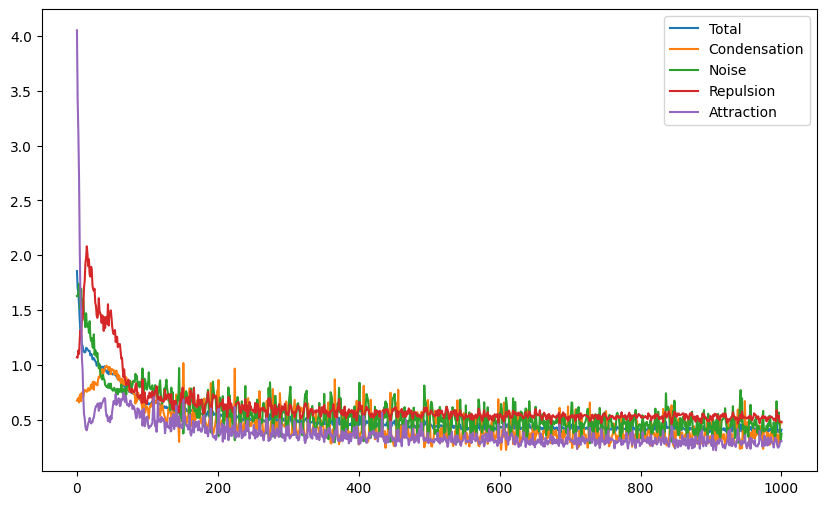

In [354]:
# Plot loss over time

import matplotlib.pyplot as plt
import numpy as np

key = ['Total', 'Condensation', 'Noise', 'Repulsion', 'Attraction']

data = list(zip(*loss_storage)) 

plt.figure(figsize=(10, 6))  

for i, sublist in enumerate(data):
    plt.plot(sublist, label=key[i])

plt.legend() 
plt.show()

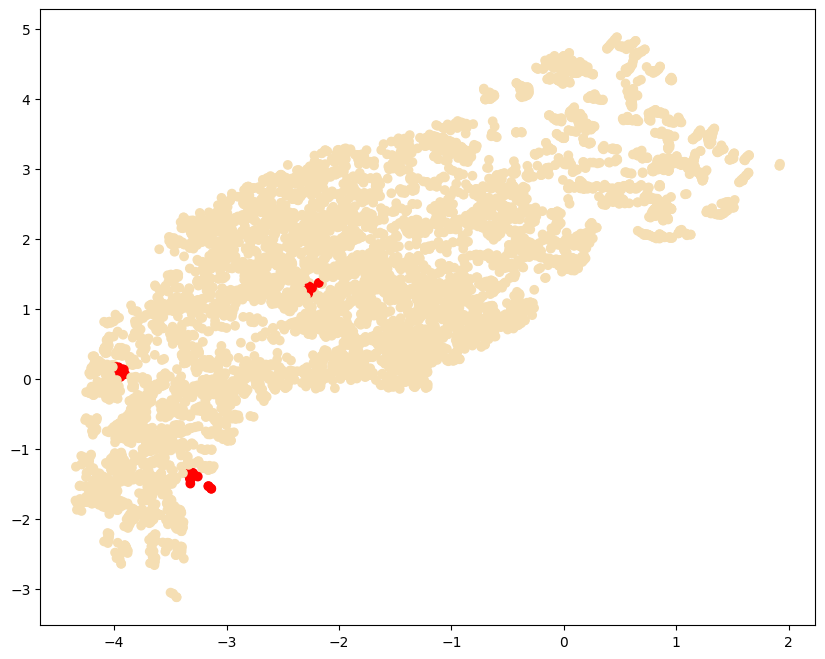

In [439]:
# View three random particle's hits in the generated latent space (colored red)

y = gravnet(raw_data[0].x) / normalization_factor
POS = y[:, 1:].detach()
ID = raw_data[0].particle_id

id_np = ID.numpy()
pos_np = POS.numpy()

unique_ids = np.unique(id_np)
highlight_id = np.random.choice(unique_ids)
highlight_id_2 = np.random.choice(unique_ids)
highlight_id_3 = np.random.choice(unique_ids)

colors = ['red' if (id == highlight_id or id == highlight_id_2 or id == highlight_id_3) else 'wheat' for id in id_np]

plt.figure(figsize=(10, 8))
plt.scatter(pos_np[:, 0], pos_np[:, 1], color=colors)
plt.show()

We can see that hits of the same particle are broadly located close together, but no clear clusters are formed. Likely the model is too small and the loss function is improperly calibrated.

In [454]:
from gnn_tracking.metrics.losses import (
    EdgeWeightFocalLoss,
    PotentialLoss,
    BackgroundLoss,
)

In [459]:
print(raw_data[0].reconstructable)

tensor([1, 1, 1,  ..., 1, 1, 1])


In [464]:
y = gravnet(raw_data[0].x) / normalization_factor
p = PotentialLoss()
p.forward(beta=torch.sigmoid(y[:,0]), x=y[:,1:], particle_id=raw_data[0].particle_id, reconstructable=raw_data[0].reconstructable, track_params=torch.ones(raw_data[0].x.size()[0]).long(), ec_hit_mask=torch.ones(raw_data[0].x.size()[0]).long())

{'attractive': tensor(527.3251, grad_fn=<SumBackward0>),
 'repulsive': tensor(0., grad_fn=<SumBackward0>)}

In [455]:
print(raw_data[0])

Data(x=[7285, 7], edge_index=[2, 0], y=[0], layer=[7285], particle_id=[7285], pt=[7285], reconstructable=[7285], sector=[7285])
